# Libraries import

In [93]:
!pip3 install spacy
!pip3 install gensim
!pip3 install pyLDAvis
!pip3 install --upgrade ipykernel
!pip3 install wordcloud
!pip3 install shap

     |████████████████████████████████| 433 kB 4.9 MB/s            
     |████████████████████████████████| 40 kB 1.0 MB/s             
  Attempting uninstall: packaging
    Found existing installation: packaging 20.9
    Uninstalling packaging-20.9:
      Successfully uninstalled packaging-20.9
You should consider upgrading via the '/Users/yopa/opt/anaconda3/bin/python -m pip install --upgrade pip' command.


In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [1]:
import spacy
#spacy.load('en_core_web_sm')
from spacy.lang.en import English
import nltk
nltk.download('wordnet')
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer
import pandas as pd
from gensim import corpora
import pickle
import gensim
import pyLDAvis.gensim_models
import numpy as np
import seaborn as sns
from collections import Counter
import matplotlib.pyplot as plt
import wordcloud

import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import shap

shap.initjs()

[nltk_data] Downloading package wordnet to /Users/yopa/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display


# 1- Topic Modeling

## Overall Text Cleaning pipeline

In [2]:
class ReviewsPreprocess:
    # CLass to tokenize reviews
    
    def __init__(self, dataframe, targetColumn):
        """ 
        Parameters:
        -----------
        dataframe: pandas dataframe
            Dataframe with the reviews and other infos
        targetColumn: string
            name of the column containing the reviews
        """
        self.reviews_ = []
        self.df_ = dataframe
        self.reviewColumn_ = targetColumn
        
    
    def preprocess(self, minWordLength):
        """ Convert each review into list of tokens
        Parameters:
        -----------
        minWordLength: integer
            minimum length of token
        """
        
        # Clean the reviews and return list of tokens
        parser = English()
        def tokenize(text):
            lda_tokens = []
            tokens = parser(text)
            for token in tokens:
                if token.orth_.isspace():
                    continue
                elif token.like_url:
                    lda_tokens.append('URL')
                elif token.orth_.startswith('@'):
                    lda_tokens.append('SCREEN_NAME')
                else:
                    lda_tokens.append(token.lower_)
            return lda_tokens
        
        # Get root of words
        def get_lemma(word):
            return WordNetLemmatizer().lemmatize(word)
        
        # Filter out stopwords
        nltk.download('stopwords')
        en_stop = set(nltk.corpus.stopwords.words('english'))
        
        
        ### Do the preprocess steps ###########
        for review in self.df_[self.reviewColumn_]:
            tokens = tokenize(review)
            tokens = [token for token in tokens if len(token) > minWordLength]
            tokens = [token for token in tokens if token not in en_stop]
            tokens = [get_lemma(token) for token in tokens]
            
            self.reviews_.append(tokens)
            
        # Add the preprocessed review as a column in the dataframe
        self.df_['tokens'] = self.reviews_
                

In [3]:
# Test object
df = pd.read_excel('skytrax_reviews.xlsx')               

In [4]:
df.head()

airline  aircraft  type_travel  type_cabin  date  seats_rating  \
0  air-france       NaN          NaN         NaN   NaN           3.0   
1  air-france       NaN          NaN         NaN   NaN           3.0   
2  air-france       NaN          NaN         NaN   NaN           3.0   
3  air-france       NaN          NaN         NaN   NaN           3.0   
4  air-france       NaN          NaN         NaN   NaN           3.0   

   cabin_staff_rating  food_rating  entertainment_rating  wifi_rating  \
0                 3.0          3.0                   4.0          3.0   
1                 4.0          4.0                   4.0          NaN   
2                 1.0          2.0                   5.0          4.0   
3                 4.0          3.0                   5.0          5.0   
4                 5.0          4.0                   4.0          5.0   

   money_rating                                             review recommended  
0           3.0   My flight from Dulles to Paris was great. My ...         yes  
1           3.0    I went for 2 months to Nice, when I arrived ...          no  
2           2.0   Yesterday Jan 25, we flew Colombo, Sri Lanka ...          no  
3           4.0    First medium-haul experience with Air France...         yes  
4           3.0    BOD-CDG-ATL: Was having some major issue wit...         yes

In [5]:
text = ReviewsPreprocess(df, 'review')

In [6]:
text.preprocess(minWordLength=4)

[nltk_data] Downloading package stopwords to /Users/yopa/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
text.df_.tokens[0]

['flight',
 'dulles',
 'paris',
 'great',
 'flight',
 'attendant',
 'super',
 'friendly',
 'unlike',
 'cabin',
 'speaking',
 'french',
 'spoke',
 'language',
 'pitch',
 'movie',
 'watch',
 'point',
 'complain',
 'pretty',
 'flight',
 'morocco',
 'service']

In [8]:
print(len(text.reviews_))

6271


## Topics extraction

In [9]:
dictionary = corpora.Dictionary(text.reviews_)
corpus = [dictionary.doc2bow(text) for text in text.reviews_]

pickle.dump(corpus, open('corpus.pkl', 'wb'))
dictionary.save('dictionary.gensim')

In [18]:
print(dictionary)

Dictionary(13786 unique tokens: ['attendant', 'cabin', 'complain', 'dulles', 'flight']...)


In [8]:
NUM_TOPICS = 80 # chose number of topics to extract
NUM_WORDS=10 # chose number of words to characterize each toic

ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=50)
ldamodel.save('model80.gensim')
topics = ldamodel.print_topics(num_words=NUM_WORDS)
#for topic in topics:
#    print(topic)
#    print('')

Idea : try to filter out words that come too often in the reviews and that doesn't help us (eg. 'flight' or country names)

In [42]:
few_reviews = corpus[:10]
for i, review in enumerate(few_reviews):
    print(ldamodel[review])
    print(text.df_['review'][i])
    print('')

# topic number and probability to belonging to this topic + associated review

[(0, 0.016462084), (1, 0.015400243), (2, 0.96813774)]
 My flight from Dulles to Paris was great. My flight attendant, was super nice and friendly unlike a few cabin crew. speaking to me in French like I spoke the language.  The seat pitch was okay for me, lots of movies to watch, food was good in my point of view. I can't complain because my trip was pretty good. The flight to Morocco was the same, good service, good food.

[(0, 0.026112175), (1, 0.9466874), (2, 0.027200479)]
  I went for 2 months to Nice, when I arrived in Nice my baggage came with me. In my return to Lebanon, my baggage didn't make it. 9 days now, I call daily and check online status of my claim daily. No news.

[(0, 0.25280702), (1, 0.24938866), (2, 0.4978043)]
 Yesterday Jan 25, we flew Colombo, Sri Lanka to Paris, a 10.5 hour flight. We were fed an OK meal about 1 hour into the flight. For the next over 7 hours we were not offered even a water. Nothing. And my coffee cup and my wife's wine glass from dinner remain

/Users/yopa/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Vizualize topics extracted

In [10]:
dictionary = gensim.corpora.Dictionary.load('dictionary.gensim')
corpus = pickle.load(open('corpus.pkl', 'rb'))
lda = gensim.models.ldamodel.LdaModel.load('model80.gensim')

In [38]:
lda_display = pyLDAvis.gensim_models.prepare(lda, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

## Assign each review to its topics

In [11]:
reviews_labelled = text.df_  # dataframe with rewiews and their corresponding tokens
topic_distribution = []
NUM_TOPICS = 80

# Loop through the reviews in 'bag of words' form
for review_bow in corpus:
    
    # Get topic distribution of the review
    topics = lda.get_document_topics(review_bow)
    topics_mapped = [0]*NUM_TOPICS
    for pair in topics:
        topics_mapped[pair[0]] = pair[1]
    topic_distribution.append(topics_mapped)
    

In [12]:
print(topic_distribution[:2])

[[0, 0.18705505, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.24387097, 0, 0, 0, 0, 0, 0, 0, 0, 0.22324228, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.1779564, 0, 0, 0, 0, 0, 0, 0, 0, 0.04225829, 0, 0, 0, 0, 0, 0.08703933, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.17188261, 0, 0, 0, 0, 0.07786797, 0, 0, 0.08179151, 0, 0, 0.412244, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.18409204, 0, 0, 0, 0, 0, 0]]


In [13]:
## Add per review topic distribution to dataframe

# Get a list of shape nb reviews * nb of topics
topic_distribution_transposed = list(np.array(topic_distribution).T)

# Add topics to data frame
for i, column in enumerate(topic_distribution_transposed):
    col_name = 'topic_'+str(i+1)
    reviews_labelled[col_name] = topic_distribution_transposed[i]
    

In [14]:
reviews_labelled.head()

airline  aircraft  type_travel  type_cabin  date  seats_rating  \
0  air-france       NaN          NaN         NaN   NaN           3.0   
1  air-france       NaN          NaN         NaN   NaN           3.0   
2  air-france       NaN          NaN         NaN   NaN           3.0   
3  air-france       NaN          NaN         NaN   NaN           3.0   
4  air-france       NaN          NaN         NaN   NaN           3.0   

   cabin_staff_rating  food_rating  entertainment_rating  wifi_rating  ...  \
0                 3.0          3.0                   4.0          3.0  ...   
1                 4.0          4.0                   4.0          NaN  ...   
2                 1.0          2.0                   5.0          4.0  ...   
3                 4.0          3.0                   5.0          5.0  ...   
4                 5.0          4.0                   4.0          5.0  ...   

   topic_71 topic_72 topic_73  topic_74  topic_75  topic_76  topic_77  \
0       0.0      0.0      0.0  0.000000  0.000000       0.0       0.0   
1       0.0      0.0      0.0  0.184092  0.000000       0.0       0.0   
2       0.0      0.0      0.0  0.000000  0.000000       0.0       0.0   
3       0.0      0.0      0.0  0.000000  0.021917       0.0       0.0   
4       0.0      0.0      0.0  0.051768  0.000000       0.0       0.0   

   topic_78  topic_79  topic_80  
0  0.000000       0.0       0.0  
1  0.000000       0.0       0.0  
2  0.000000       0.0       0.0  
3  0.184639       0.0       0.0  
4  0.000000       0.0       0.0  

[5 rows x 94 columns]

# 2- Insights 

## Filter out reviews

In [15]:
# List of topics in our scope
topics_in_scope = [78, 7, 20, 69, 29, 67, 46, 43, 15, 27, 52, 31, 30, 65, 75]  # took the topics related to the word 'cabin'
topics_in_scope = ['topic_'+str(num) for num in topics_in_scope]
print(topics_in_scope)

['topic_78', 'topic_7', 'topic_20', 'topic_69', 'topic_29', 'topic_67', 'topic_46', 'topic_43', 'topic_15', 'topic_27', 'topic_52', 'topic_31', 'topic_30', 'topic_65', 'topic_75']


In [16]:
# Add sum of probability of topics in scope in our dataframe
reviews_labelled['topics_in_scope'] = 0
for topic in topics_in_scope:
    reviews_labelled['topics_in_scope'] += reviews_labelled[topic]

In [17]:
reviews_labelled.head()

airline  aircraft  type_travel  type_cabin  date  seats_rating  \
0  air-france       NaN          NaN         NaN   NaN           3.0   
1  air-france       NaN          NaN         NaN   NaN           3.0   
2  air-france       NaN          NaN         NaN   NaN           3.0   
3  air-france       NaN          NaN         NaN   NaN           3.0   
4  air-france       NaN          NaN         NaN   NaN           3.0   

   cabin_staff_rating  food_rating  entertainment_rating  wifi_rating  ...  \
0                 3.0          3.0                   4.0          3.0  ...   
1                 4.0          4.0                   4.0          NaN  ...   
2                 1.0          2.0                   5.0          4.0  ...   
3                 4.0          3.0                   5.0          5.0  ...   
4                 5.0          4.0                   4.0          5.0  ...   

   topic_72 topic_73  topic_74  topic_75  topic_76  topic_77  topic_78  \
0       0.0      0.0  0.000000  0.000000       0.0       0.0  0.000000   
1       0.0      0.0  0.184092  0.000000       0.0       0.0  0.000000   
2       0.0      0.0  0.000000  0.000000       0.0       0.0  0.000000   
3       0.0      0.0  0.000000  0.021917       0.0       0.0  0.184639   
4       0.0      0.0  0.051768  0.000000       0.0       0.0  0.000000   

   topic_79  topic_80  topics_in_scope  
0       0.0       0.0         0.467113  
1       0.0       0.0         0.000000  
2       0.0       0.0         0.604916  
3       0.0       0.0         0.620593  
4       0.0       0.0         0.404490  

[5 rows x 95 columns]

<AxesSubplot:xlabel='topics_in_scope', ylabel='Count'>

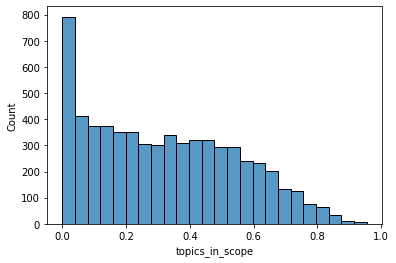

In [51]:
sns.histplot(data=reviews_labelled, x='topics_in_scope')

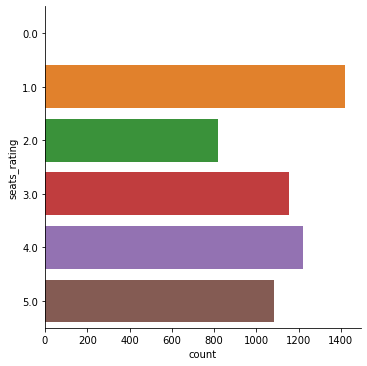

In [52]:
sns.catplot(data=reviews_labelled, y='seats_rating', kind='count')

In [59]:
threshold = 0.5
reviews_labelled.loc[reviews_labelled['topics_in_scope']>threshold, ["review"]].head(10).values

# looks ok : most of reviews are somehow related to cabin/seats

array([[" Yesterday Jan 25, we flew Colombo, Sri Lanka to Paris, a 10.5 hour flight. We were fed an OK meal about 1 hour into the flight. For the next over 7 hours we were not offered even a water. Nothing. And my coffee cup and my wife's wine glass from dinner remained in the cupholders untouched. For over 7 hours the flight attendants were non-existent. Many people around us complaining. No excuse for this on a smooth flight with no turbulence."],
       ["  First medium-haul experience with Air France. This is part of a connecting flight from LHR-MIA via CDG. Check-in at LHR was swift, thanks to Sky Priority (customers flying Premium Economy get Sky Priority access). Due to COVID, check-in meant extra checks and formalities during check-in. All my documents were verified in less than 20 minutes. I received my onward boarding pass to MIA. This is my first medium-haul trip with Air France. The equipment used on this flight was a 10 year old Boeing 777-300ER. I was among the first pass

## Word clouds

In [60]:
corpus[1]

[(21, 1),
 (22, 2),
 (23, 1),
 (24, 1),
 (25, 2),
 (26, 1),
 (27, 1),
 (28, 1),
 (29, 1),
 (30, 1)]

In [18]:
plt.rcParams["figure.figsize"] = [16, 9]

def make_word_cloud(reviews_token, stop_words=None, ngrams_number=1, number_top_words=10):
    
    def create_ngrams(token_list, nb_elements, stop_words=None):
        """
        Create n-grams for list of tokens
        Parameters
        ----------
        token_list : list
            list of strings
        nb_elements :
            number of elements in the n-gram
        Returns
        -------
        Generator
            generator of all n-grams
        """
        if stop_words is not None:
            token_list = [token for token in token_list if token not in stop_words]
        ngrams = zip(*[token_list[index_token:] for index_token in range(nb_elements)])
        
        return list(" ".join(ngram) for ngram in ngrams)
    
    
    list_ngrams = []
    for review in reviews_token:
        ngram = create_ngrams(review, nb_elements=ngrams_number, stop_words=stop_words)
        list_ngrams += ngram
    
    counter = Counter(list_ngrams)
        
    word_cloud = wordcloud.WordCloud(stopwords=None).generate_from_frequencies(counter)
    plt.imshow(word_cloud)
    plt.axis("off")
    plt.show()
    
    print(counter.most_common(number_top_words))
  

In [74]:
Counter(create_ngrams(reviews_labelled.tokens[0], 2))

Counter({'flight dulles': 1,
         'dulles paris': 1,
         'paris great': 1,
         'great flight': 1,
         'flight attendant': 1,
         'attendant super': 1,
         'super friendly': 1,
         'friendly unlike': 1,
         'unlike cabin': 1,
         'cabin speaking': 1,
         'speaking french': 1,
         'french spoke': 1,
         'spoke language': 1,
         'language pitch': 1,
         'pitch movie': 1,
         'movie watch': 1,
         'watch point': 1,
         'point complain': 1,
         'complain pretty': 1,
         'pretty flight': 1,
         'flight morocco': 1,
         'morocco service': 1})

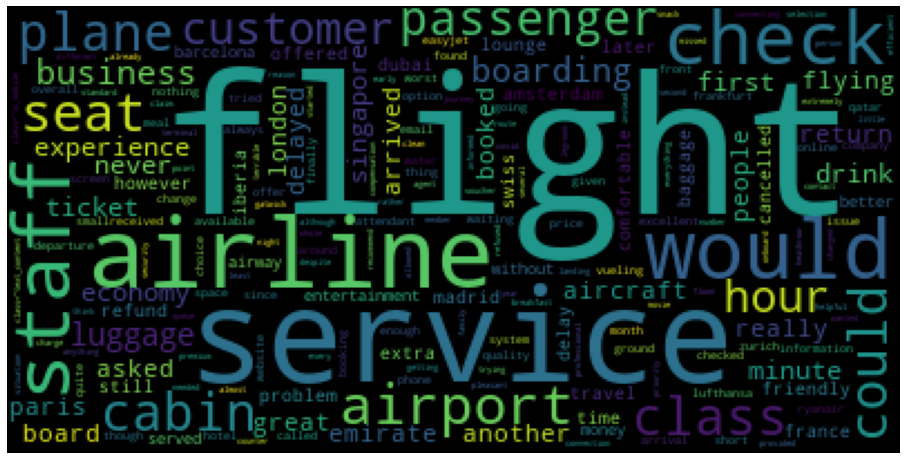

[('flight', 12922), ('service', 4388), ('airline', 3791), ('would', 2598), ('staff', 2516), ('check', 2365), ('airport', 2239), ('seat', 2142), ('cabin', 2050), ('plane', 1980)]


In [84]:
make_word_cloud(reviews_labelled.tokens)

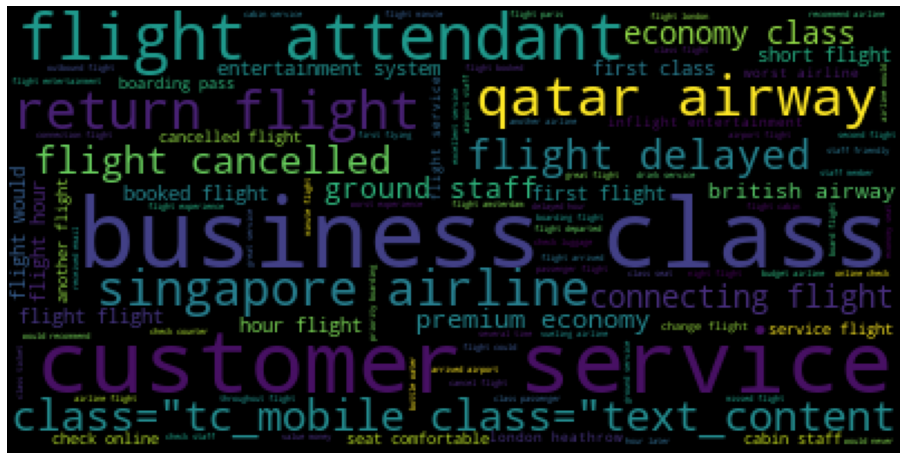

[('business class', 1272), ('customer service', 1088), ('flight attendant', 506), ('qatar airway', 401), ('return flight', 381), ('singapore airline', 365), ('class="tc_mobile class="text_content', 359), ('flight delayed', 355), ('flight cancelled', 322), ('connecting flight', 315)]


In [78]:
make_word_cloud(reviews_labelled.tokens, ngrams_number=2)

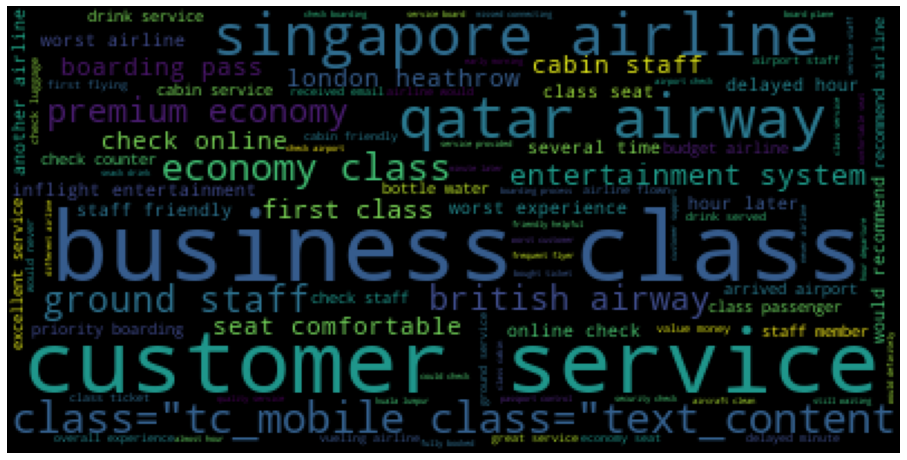

[('business class', 1272), ('customer service', 1088), ('qatar airway', 401), ('singapore airline', 365), ('class="tc_mobile class="text_content', 359), ('economy class', 296), ('ground staff', 270), ('premium economy', 245), ('british airway', 241), ('entertainment system', 190)]


In [85]:
make_word_cloud(reviews_labelled.tokens, ngrams_number=2, stop_words=['flight'])

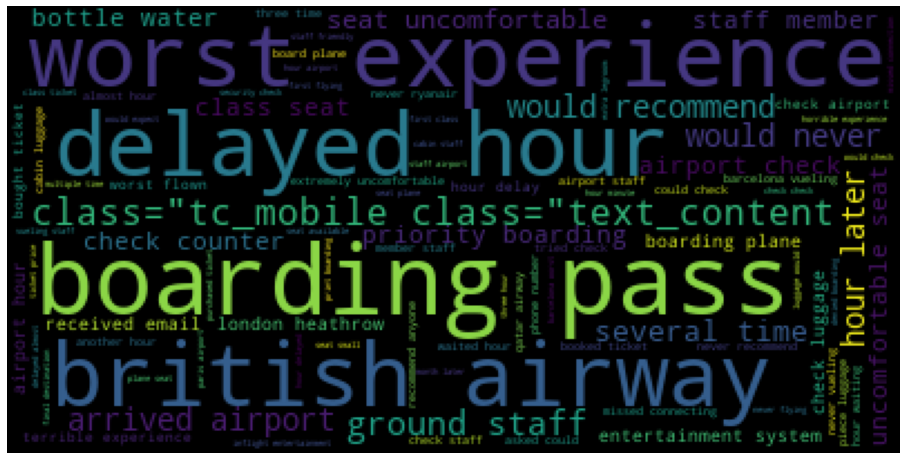

[('boarding pass', 61), ('worst experience', 55), ('delayed hour', 53), ('british airway', 53), ('class="tc_mobile class="text_content', 51), ('ground staff', 45), ('hour later', 37), ('would recommend', 36), ('arrived airport', 35), ('would never', 34)]


In [88]:
make_word_cloud(reviews_labelled[reviews_labelled['seats_rating']<2].tokens, ngrams_number=2, 
                stop_words=['flight', 'business', 'economy', 'airline', 'online', 'customer', 'service'])

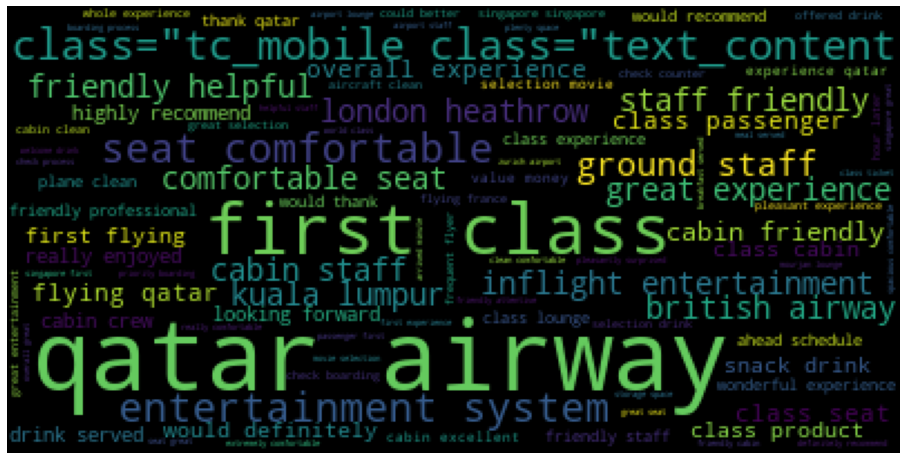

[('qatar airway', 238), ('first class', 93), ('class="tc_mobile class="text_content', 60), ('seat comfortable', 56), ('entertainment system', 56), ('ground staff', 39), ('inflight entertainment', 36), ('staff friendly', 34), ('cabin staff', 32), ('friendly helpful', 32)]


In [91]:
make_word_cloud(reviews_labelled[reviews_labelled['seats_rating']==5].tokens, ngrams_number=2, 
                stop_words=['flight', 'business', 'economy', 'airline', 'online', 'customer', 'service'])

## Sentiment Analysis - Draft

In [95]:
corpus,y = shap.datasets.imdb()
corpus_train, corpus_test, y_train, y_test = train_test_split(corpus, y, test_size=0.2, random_state=7)

vectorizer = TfidfVectorizer(min_df=10)
X_train = vectorizer.fit_transform(corpus_train)
X_test = vectorizer.transform(corpus_test)

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [96]:
corpus

["Story of a man who has unnatural feelings for a pig. Starts out with a opening scene that is a terrific example of absurd comedy. A formal orchestra audience is turned into an insane, violent mob by the crazy chantings of it's singers. Unfortunately it stays absurd the WHOLE time with no general narrative eventually making it just too off putting. Even those from the era should be turned off. The cryptic dialogue would make Shakespeare seem easy to a third grader. On a technical level it's better than you might think with some good cinematography by future great Vilmos Zsigmond. Future stars Sally Kirkland and Frederic Forrest can be seen briefly.\n",
 "Airport '77 starts as a brand new luxury 747 plane is loaded up with valuable paintings & such belonging to rich businessman Philip Stevens (James Stewart) who is flying them & a bunch of VIP's to his estate in preparation of it being opened to the public as a museum, also on board is Stevens daughter Julie (Kathleen Quinlan) & her so

In [97]:
y

array([False, False, False, ...,  True,  True,  True])

In [99]:
X_train[:2, :2]

<2x2 sparse matrix of type '<class 'numpy.float64'>'
	with 0 stored elements in Compressed Sparse Row format>

## Sentiment Analysis

In [19]:
# Add colunm with preprocessed reviews
reviews_labelled['preprocessed_review'] = [' '.join(token) for token in reviews_labelled['tokens']]

In [20]:
reviews_labelled['preprocessed_review'].head()

0    flight dulles paris great flight attendant sup...
1    month arrived baggage return lebanon baggage d...
2    yesterday colombo lanka paris flight flight ho...
3    first medium experience france connecting flig...
4    major issue delta airline return numerous canc...
Name: preprocessed_review, dtype: object

In [21]:
# Label each review into 'Positive', 'Negative', 'Neutral' according to the seats rating
df_sentiment =  reviews_labelled.loc[:, ['preprocessed_review', 'seats_rating', 'tokens']]
df_sentiment = df_sentiment.loc[(df_sentiment['seats_rating']<=2) |  (df_sentiment['seats_rating']==5)]

df_sentiment.loc[df_sentiment['seats_rating']<=2, 'sentiment'] = False
df_sentiment.loc[df_sentiment['seats_rating']==5, 'sentiment'] = True

In [22]:
df_sentiment.head()

preprocessed_review  seats_rating  \
6   booked nightmare supposed france changed fligh...           5.0   
8   frankfurt toronto paris first flight pandemic ...           5.0   
9   frankfurt toronto paris first flight pandemic ...           5.0   
10  short flight brand airplane france delivered g...           5.0   
11  france first thanksgiving quick europe check b...           5.0   

                                               tokens sentiment  
6   [booked, nightmare, supposed, france, changed,...      True  
8   [frankfurt, toronto, paris, first, flight, pan...      True  
9   [frankfurt, toronto, paris, first, flight, pan...      True  
10  [short, flight, brand, airplane, france, deliv...      True  
11  [france, first, thanksgiving, quick, europe, c...      True

In [23]:
# Transform our data in correct format
vectorizer = TfidfVectorizer(min_df=10)
X_train = vectorizer.fit_transform(df_sentiment.preprocessed_review)
y_train = list(df_sentiment.sentiment)

In [24]:
# Fit logistic regression model
model = sklearn.linear_model.LogisticRegression(penalty="l2", C=0.1)
model.fit(X_train, y_train)

LogisticRegression(C=0.1)

In [25]:
X_train

<3326x1906 sparse matrix of type '<class 'numpy.float64'>'
	with 114287 stored elements in Compressed Sparse Row format>

The option feature_dependence has been renamed to feature_perturbation!
The option feature_perturbation="independent" is has been renamed to feature_perturbation="interventional"!
The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


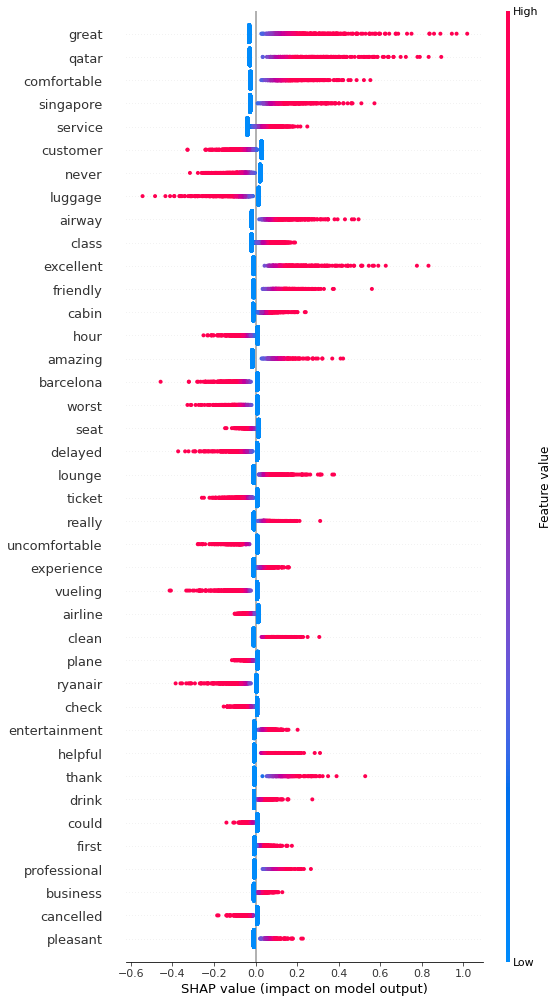

In [26]:
# Explain the model 
explainer = shap.LinearExplainer(model, X_train, feature_dependence="independent")
shap_values = explainer.shap_values(X_train)
X_train_array = X_train.toarray() # we need to pass a dense version for the plotting functions

# Summarize the effects of all features
shap.summary_plot(shap_values, X_train_array, feature_names=vectorizer.get_feature_names(), max_display=40)

In [27]:
# Zoom in on a specific word
def find_ngram(reviews_token, target_word, stop_words=None, ngrams_number=1, number_top_words=10):
    
    def create_ngrams(token_list, nb_elements, stop_words=None):
        """
        Create n-grams for list of tokens
        Parameters
        ----------
        token_list : list
            list of strings
        nb_elements :
            number of elements in the n-gram
        Returns
        -------
        Generator
            generator of all n-grams
        """
        if stop_words is not None:
            token_list = [token for token in token_list if token not in stop_words]
        ngrams = zip(*[token_list[index_token:] for index_token in range(nb_elements)])
        
        # Only keep ngram with target_word
        ngrams_retained = []
        for ngram in ngrams:
            keep = False
            
            for element in ngram:
                if element==target_word:
                    keep = True
            if keep:
                ngrams_retained.append(ngram)
            
        
        return list(" ".join(ngram) for ngram in ngrams_retained)
    
    
    list_ngrams = []
    for review in reviews_token:
        ngram = create_ngrams(review, nb_elements=ngrams_number, stop_words=stop_words)
        list_ngrams += ngram
    
    counter = Counter(list_ngrams)
        
    return counter.most_common(number_top_words)

In [42]:
find_ngram(df_sentiment.loc[df_sentiment['sentiment']==False].tokens, target_word='economy',
           ngrams_number=3, number_top_words=20)

[('business class economy', 8),
 ('economy class seat', 6),
 ('downgraded premium economy', 5),
 ('economy class passenger', 5),
 ('premium economy economy', 4),
 ('downgraded economy class', 4),
 ('flying economy class', 4),
 ('economy seat flight', 4),
 ('economy business class', 4),
 ('premium economy seat', 4),
 ('seat premium economy', 4),
 ('airline premium economy', 4),
 ('class seat economy', 3),
 ('france premium economy', 3),
 ('premium economy france', 3),
 ('upgraded premium economy', 3),
 ('flight premium economy', 3),
 ('economy seat recline', 3),
 ('economy class cabin', 3),
 ('premium economy really', 3)]

-> Passengers are asking for extra legrooms

In [34]:
find_ngram(df_sentiment.loc[df_sentiment['sentiment']==False].tokens, target_word='light',
           ngrams_number=2, number_top_words=20)

[('cabin light', 4),
 ('light turned', 3),
 ('light breakfast', 2),
 ('light switched', 2),
 ('light never', 2),
 ('toilet light', 2),
 ('seatbelt light', 2),
 ('sleep light', 2),
 ('switch light', 2),
 ('light waited', 2),
 ('light early', 1),
 ('hour light', 1),
 ('issue light', 1),
 ('light checkin', 1),
 ('flash light', 1),
 ('light godzilla', 1),
 ('night light', 1),
 ('classic light', 1),
 ('light comfort', 1),
 ('northern light', 1)]

-> Seats are uncomfortable

In [150]:
print('Negative')
print(find_ngram(df_sentiment.loc[df_sentiment['sentiment']==False].tokens, target_word='screen',
           ngrams_number=2, number_top_words=20))

print('Positive')
print(find_ngram(df_sentiment.loc[df_sentiment['sentiment']==True].tokens, target_word='screen',
           ngrams_number=2, number_top_words=20))

Negative
[('touch screen', 12), ('screen flight', 8), ('entertainment screen', 8), ('screen small', 6), ('seat screen', 5), ('video screen', 5), ('flight screen', 3), ('screen selection', 3), ('system screen', 3), ('uncomfortable screen', 3), ('screen broken', 3), ('screen front', 3), ('screen changed', 3), ('overhead screen', 3), ('large screen', 3), ('small screen', 3), ('screen working', 2), ('around screen', 2), ('screen looked', 2), ('tired screen', 2)]
None
Positive
[('large screen', 7), ('screen large', 6), ('entertainment screen', 4), ('screen movie', 4), ('touch screen', 4), ('quality screen', 3), ('screen great', 3), ('screen worked', 2), ('screen better', 2), ('movie screen', 2), ('screen decent', 2), ('small screen', 2), ('resolution screen', 2), ('wider screen', 2), ('screen departure', 2), ('plane screen', 1), ('screen everything', 1), ('outdated screen', 1), ('screen pretty', 1), ('beautiful screen', 1)]
None


-> People value size and quality of the screen